# Import

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import pandas as pd
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint

# Definition of the model

For the fitting we use the cumulative case numbers, we need to add a compartment here to count them. In our model, all detected cases end up in Q2, which is why we count the number of people entering there.


In [2]:
def f(xs, t, ps):
    '''Coupled Opinion and Epidemic Model'''
    timeslot_1 = 589 - 549 #01.07.2021 - 10.08.2021
    timeslot_2 = timeslot_1 + 689-589 # 10.08.2021 - 18.11.2021

    try:
        if t<(timeslot_1):
            ρ = ps['ρ1'].value 
            σ = ps['σ1'].value 
            τ = ps['τ1'].value 
        elif t>=timeslot_1 and t < timeslot_2:
            ρ = ps['ρ2'].value 
            σ = ps['σ2'].value 
            τ = ps['τ2'].value
        else:
            ρ = ps['ρ3'].value 
            σ = ps['σ3'].value 
            τ = ps['τ3'].value

    except:
        ρ,σ,τ = ps
        
    S,E,Q_1,Q_2,I,V,    L,U,D,R,H, Q_C = xs
    N = S + E + Q_1 + Q_2 + I + V
    Q = Q_1 + Q_2
    
    R_G = a*R/(1+a*R)

    η_1 = 1/2.5 * 0.897 * (S/(S+V))
    η_2 = 1/2.5 * 0.103
    η_3 = 1/2.5 * 0.897 * (V/(S+V))
    
    dS = -β * I/(N-Q) * S - ψ * ( 1 - (R + τ * U) / N + D/N ) * S - ρ * (1 - (R + τ * U) / N) * S + η_1 * Q_1
    dE = β * I/(N-Q) * S + β * δ * I/(N-Q) * V - ρ * ( 1- (R + τ * U)/N) * E - γ * E
    dQ_1 = ρ * ( 1- (R + τ * U)/N) * S + ρ * ( 1- (R + τ * U)/N) * E + ρ * ( 1- (R + τ * U)/N) * V - η_1 * Q_1 - η_2 * Q_1 - η_3 * Q_1
    dQ_2 = σ * ( 1- R/N) * I + η_2 * Q_1 - r_2 * Q_2
    dI = γ * E - σ * ( 1- R/N) * I - r_1 * I
    dV = r_1 * I + r_2 * Q_2 + η_3 * Q_1 + ψ * ( 1- (R + τ * U)/N + D/N) * S - β * δ * I/(N-Q) * V - ρ * ( 1- (R + τ * U)/N) * V
    
    dL = -α * R/N * L*(1-(I+Q_2)/N) - α * U/N * L - α * D/N * L*(1+(I+Q_2)/N) + ϕ * R + ϕ * H
    dU = α * U/N * L-  χ* R_G/N * U *(1-(I+Q_2)/N) - χ * D/N * U*(1+(I+Q_2)/N) - λ * U
    dD = α * D/N * L*(1+(I+Q_2)/N) + χ * D/N * U*(1+(I+Q_2)/N) - λ * D 
    dR = α * R/N * L* (1-(I+Q_2)/N) + χ * R_G/N * U*(1-(I+Q_2)/N) - ϕ * R 
    dH = λ * D + λ * U - ϕ * H
    
    #cumulative numbers:
    dQ_C = σ * ( 1- R/N) * I + η_2 * Q_1
    
    
    return [dS,dE,dQ_1,dQ_2,dI,dV,dL,dU,dD,dR,dH,dQ_C]

# Definition of the fixed parameters

In [3]:
#epidemic model
β = 0.4
r_1 = 0.1
r_2 = 1/12
γ = 1/4
δ = 0.28
ψ = 0.00265


#Oppinion model
α = 0.071
ϕ = 1.9685e-5
χ = 0.0031
λ = 4.2972e-5

#Holling Type 2
a = 0.8

# Definition of the residual and the initial conditions

The residual is needed for the optimisation.

In [4]:
def g(t, x0, ps):
    """Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0"""
    x = odeint(f, x0, t, args=(ps,))
    return x

def residual(ps, ts, data):
    
    #initial conditions for the compartments
    U = 140000
    D = 1400000
    R = 350000
    H = 0
    L = 70000000 - D - R - H - U

    E = ps['E'].value
    Q_1 = ps['Q_1'].value
    Q_2 = 3649881-3642450 #calculated from the incidence  of the 01.07.2021
    I = ps['I'].value
    V = 34715161
    S = 70000000 - E - Q_1 - Q_2 - I - V
    
    #define the number of people which are or were already infected 
    Q_C = 3729033
    
    x0 = [S, E, Q_1, Q_2, I, V,    #epidemics
      L, U, D, R, H, Q_C]           #oppinion;

    model = g(ts, x0, ps) 
    
    #return the cumulative compartment
    return (model[:,11]-data).ravel()

# Importing and preparing data, setting time

The exact number of new infections is usually not available, instead we use cumulative case numbers. These are calculated and stored in an array.

In [5]:
path = '/Users/tobiasgerwald/Library/CloudStorage/OneDrive-Persönlich/Desktop/Case Studies Life Sciences/Daten/' #path to exel with rki case numbers


data = pd.read_excel(path + '00 Bundeslaender Gesamt.xlsx',
                     sheet_name='Gesamt',
                     header=0)



data = data['Fälle']
train = []

days = 732 - 549 #from 01.07.2021 to 31.12.2021

#depends on the days we want to observe
#t = np.linspace(0,days, days+1)
t1 = np.linspace(0, 30, 31, dtype = 'int32')
t2 = np.linspace(41, 120, 80, dtype = 'int32')
t3 = np.linspace(141, 171, 31, dtype = 'int32')
t = np.concatenate((t1, t2, t3), axis=None)
print(t)


t4 = np.linspace(31, 40, 10, dtype = 'int32')
t5 = np.linspace(121, 140, 20, dtype = 'int32')
t6 = np.linspace(172, 183, 12, dtype = 'int32')
tval = np.concatenate((t4, t5, t6), axis=None)
print(tval)


#range depends on the dates where we start and where we end
for i in range(days+1):
    train.append(sum(data[0:548+i]))
data = np.array(train)
print(data)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171]
[ 31  32  33  34  35  36  37  38  39  40 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 172 173 174 175 176 177
 178 179 180 181 182 183]
[3739560 3740256 3740889 3741472 3742398 3743412 3744413 3745460 3746492
 3747544 3748496 3749928 3751576 3753198 3754750 3756349 3757871 3759232
 3761227 3763399 3765521 3767464 3769536 3771454 3773142 3775596 3778328
 3781046 3783356 3785871 3788270

# Define the parameters we want to fit and their range


In [6]:
params = Parameters()
params.add('ρ1', value=0.5, min=0, max=1)
params.add('σ1', value=0.25, min=0, max=0.5)
params.add('τ1', value=0.5, min=0, max=1)

params.add('ρ2', value=0.5, min=0, max=1)
params.add('σ2', value=0.25, min=0, max=0.5)
params.add('τ2', value=0.5, min=0, max=1)

params.add('ρ3', value=0.5, min=0, max=1)
params.add('σ3', value=0.25, min=0, max=0.5)
params.add('τ3', value=0.5, min=0, max=1)

params.add('E', value=100, min=10, max=10000)
params.add('Q_1', value=5000, min=1000, max=10000)
params.add('I', value=1000, min=100, max=10000)

# Fit the model and find predicted values


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 572
    # data points      = 142
    # variables        = 12
    chi-square         = 1.5466e+11
    reduced chi-square = 1.1897e+09
    Akaike info crit   = 2978.83421
    Bayesian info crit = 3014.30414
[[Variables]]
    ρ1:   3.0607e-04 +/- 7.3736e-04 (240.91%) (init = 0.5)
    σ1:   0.12645765 +/- 0.25290088 (199.99%) (init = 0.25)
    τ1:   0.91176084 +/- 9.61488083 (1054.54%) (init = 0.5)
    ρ2:   0.00106899 +/- 2.5571e-04 (23.92%) (init = 0.5)
    σ2:   0.01558601 +/- 0.09036970 (579.81%) (init = 0.25)
    τ2:   0.02267971 +/- 2.58695506 (11406.48%) (init = 0.5)
    ρ3:   0.01008196 +/- 0.14422147 (1430.49%) (init = 0.5)
    σ3:   7.2405e-10 +/- 0.00406725 (561736794.37%) (init = 0.25)
    τ3:   0.30638422 +/- 174.739106 (57032.67%) (init = 0.5)
    E:    4778.55599 +/- 141683.955 (2965.00%) (init = 100)
    Q_1:  8436.79731 +/- 1405.84977 (16.66%) (init = 5000)
    I:    6148.27993 +/- 75310.8798 (122

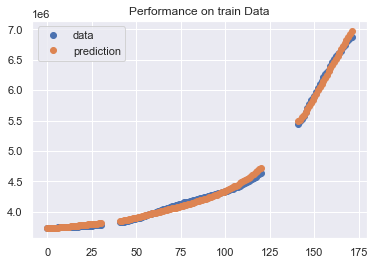

In [7]:
result = minimize(residual, params, args=(t, data[t]), method='leastsq')
final = data[t] + result.residual.reshape(data[t].shape)

# plot data and fitted curves
plt.plot(t, data[t], 'o')
plt.plot(t, final, 'o')
plt.title('Performance on train Data')
plt.legend(['data', 'prediction']);


# display fitted statistics
report_fit(result)

In [8]:
#initial conditions for the compartments
U = 140000
D = 1400000
R = 350000
H = 0
L = 70000000 - D - R - H - U

E = result.params['E'].value
I = result.params['I'].value
Q_1 = result.params['Q_1'].value
Q_2 = 3649881-3642450
V = 34715161
S = 70000000 - E - Q_1 - Q_2 - I - V

Q_C = 3729033

x0 = [S, E, Q_1, Q_2, I, V,    #epidemics
      L, U, D, R, H, Q_C] 

ttotal = np.linspace(0,183,184)

x = odeint(f, x0, ttotal, args=(result.params,))

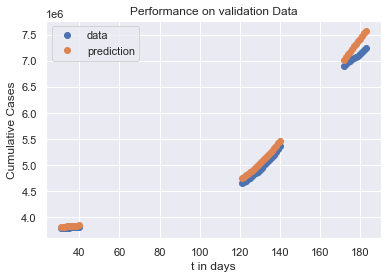

<Figure size 3000x2000 with 0 Axes>

In [9]:
plt.plot(tval,data[tval], 'o')
plt.plot(tval,x[:,11][tval], 'o')
plt.title('Performance on validation Data')
plt.legend(['data', 'prediction'])
plt.xlabel('t in days')
plt.ylabel('Cumulative Cases')
plt.figure(dpi=500)
plt.show()

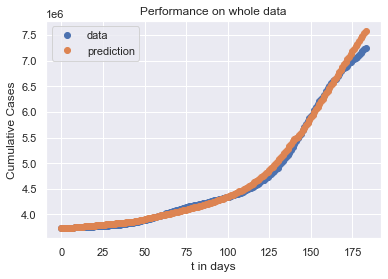

In [10]:
plt.plot(ttotal,data, 'o')
plt.plot(ttotal,x[:,11], 'o')
plt.title('Performance on whole data')
plt.legend(['data', 'prediction'])
plt.xlabel('t in days')
plt.ylabel('Cumulative Cases')
plt.show()